# Fiscal Risk and Government Debt

## Contents

- [Fiscal Risk and Government Debt](#Fiscal-Risk-and-Government-Debt)  
  - [Overview](#Overview)  
  - [The economy](#The-economy)  
  - [Long simulation](#Long-simulation)  
  - [Asymptotic mean and rate of convergence](#Asymptotic-mean-and-rate-of-convergence)  

## Overview

This lecture studies government debt in an AMSS
economy [[AMSS02]](https://lectures.quantecon.org/py/zreferences.html#amss-2002) of the type described in [Optimal Taxation without State-Contingent Debt](https://lectures.quantecon.org/py/amss.html#)

We study the behavior of government debt  as time $ t \rightarrow + \infty $

We use these techniques

> - simulations  
- a regression coefficient from the tail of a long simulation that allows us to verify that  the asymptotic mean of government debt solves
  a fiscal-risk minimization  problem  
- an approximation to the mean of an ergodic distribution of government debt  
- an approximation  to the rate of convergence to an ergodic distribution of government debt  



We apply tools applicable to  more general incomplete markets economies that are presented on pages 648 - 650 in section III.D
of [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) (BEGS)

We study an  [[AMSS02]](https://lectures.quantecon.org/py/zreferences.html#amss-2002) economy with  three Markov states driving government expenditures

> - In a [previous lecture](https://lectures.quantecon.org/py/amss2.html#), we showed that with only two Markov states, it is possible that eventually endogenous
  interest rate fluctuations support complete markets allocations and Ramsey outcomes  
- The presence of three states  prevents the full spanning that eventually prevails in the two-state example featured in
  [Fiscal Insurance via Fluctuating Interest Rates](https://lectures.quantecon.org/py/amss2.html#)  



The lack of full spanning means that the ergodic distribution of the par value of government debt is nontrivial, in contrast to the situation
in [Fiscal Insurance via Fluctuating Interest Rates](https://lectures.quantecon.org/py/amss2.html#)  where  the ergodic distribution of the par value is concentrated on one point

Nevertheless,   [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) (BEGS) establish  for general settings that include ours, the Ramsey
planner steers government assets to a level that comes
**as close as possible** to providing full spanning in a precise a sense defined by
BEGS that we describe below

We use code constructed [in a previous lecture](https://lectures.quantecon.org/py/amss2.html#)

**Warning:** Key equations in  [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) section III.D carry  typos  that we correct below

## The economy

As in [Optimal Taxation without State-Contingent Debt](https://lectures.quantecon.org/py/amss.html#) and [Optimal Taxation with State-Contingent Debt](https://lectures.quantecon.org/py/opt_tax_recur.html#),
we assume that the  representative agent has  utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

We work directly with labor supply instead of leisure

We assume that

$$
c_t + g_t = n_t
$$

The Markov state $ s_t $ takes **three** values, namely,  $ 0,1,2 $

The initial Markov state is $ 0 $

The Markov transition matrix is $ (1/3) I $ where $ I $ is a $ 3 \times 3 $ identity matrix, so the $ s_t $ process is i.i.d.

Government expenditures $ g(s) $ equal $ .1 $ in Markov state $ 0 $, $ .2 $ in Markov state $ 1 $, and $ .3 $
in Markov state $ 2 $

We set preference parameters

$$
\begin{aligned}
\beta & = .9 \cr
\sigma & = 2  \cr
\gamma & = 2
\end{aligned}
$$

The following Python code sets up the economy

In [1]:
import numpy as np


class CRRAutility:

    def __init__(self,
                 β=0.9,
                 σ=2,
                 γ=2,
                 π=0.5*np.ones((2, 2)),
                 G=np.array([0.1, 0.2]),
                 Θ=np.ones(2),
                 transfers=False):

        self.β, self.σ, self.γ = β, σ, γ
        self.π, self.G, self.Θ, self.transfers = π, G, Θ, transfers

    # Utility function
    def U(self, c, n):
        σ = self.σ
        if σ == 1.:
            U = np.log(c)
        else:
            U = (c**(1 - σ) - 1) / (1 - σ)
        return U - n**(1 + self.γ) / (1 + self.γ)

    # Derivatives of utility function
    def Uc(self, c, n):
        return c**(-self.σ)

    def Ucc(self, c, n):
        return -self.σ * c**(-self.σ - 1)

    def Un(self, c, n):
        return -n**self.γ

    def Unn(self, c, n):
        return -self.γ * n**(self.γ - 1)

### First  and second moments

We’ll want  first and second moments of some key random variables below

The following code computes these moments; the code is recycled from [Fiscal Insurance via Fluctuating Interest Rates](https://lectures.quantecon.org/py/amss2.html#)

In [2]:
def mean(x, s):
    '''Returns mean for x given initial state'''
    x = np.array(x)
    return x @ u.π[s]

def variance(x, s):
    x = np.array(x)
    return x**2 @ u.π[s] - mean(x, s)**2

def covariance(x, y, s):
    x, y = np.array(x), np.array(y)
    return x * y @ u.π[s] - mean(x, s) * mean(y, s)

## Long simulation

To generate a long simulation we use the following code

We begin by showing the code that we used in earlier lectures on the AMSS model

Here it is

In [3]:
import numpy as np
from scipy.optimize import root
from quantecon import MarkovChain


class SequentialAllocation:

    '''
    Class that takes CESutility or BGPutility object as input returns
    planner's allocation as a function of the multiplier on the
    implementability constraint μ.
    '''

    def __init__(self, model):

        # Initialize from model object attributes
        self.β, self.π, self.G = model.β, model.π, model.G
        self.mc, self.Θ = MarkovChain(self.π), model.Θ
        self.S = len(model.π)  # Number of states
        self.model = model

        # Find the first best allocation
        self.find_first_best()

    def find_first_best(self):
        '''
        Find the first best allocation
        '''
        model = self.model
        S, Θ, G = self.S, self.Θ, self.G
        Uc, Un = model.Uc, model.Un

        def res(z):
            c = z[:S]
            n = z[S:]
            return np.hstack([Θ * Uc(c, n) + Un(c, n), Θ * n - c - G])

        res = root(res, 0.5 * np.ones(2 * S))

        if not res.success:
            raise Exception('Could not find first best')

        self.cFB = res.x[:S]
        self.nFB = res.x[S:]

        # Multiplier on the resource constraint
        self.ΞFB = Uc(self.cFB, self.nFB)
        self.zFB = np.hstack([self.cFB, self.nFB, self.ΞFB])

    def time1_allocation(self, μ):
        '''
        Computes optimal allocation for time t >= 1 for a given μ
        '''
        model = self.model
        S, Θ, G = self.S, self.Θ, self.G
        Uc, Ucc, Un, Unn = model.Uc, model.Ucc, model.Un, model.Unn

        def FOC(z):
            c = z[:S]
            n = z[S:2 * S]
            Ξ = z[2 * S:]
            return np.hstack([Uc(c, n) - μ * (Ucc(c, n) * c + Uc(c, n)) - Ξ,          # FOC of c
                              Un(c, n) - μ * (Unn(c, n) * n + Un(c, n)) + \
                              Θ * Ξ,  # FOC of n
                              Θ * n - c - G])

        # Find the root of the first order condition
        res = root(FOC, self.zFB)
        if not res.success:
            raise Exception('Could not find LS allocation.')
        z = res.x
        c, n, Ξ = z[:S], z[S:2 * S], z[2 * S:]

        # Compute x
        I = Uc(c, n) * c + Un(c, n) * n
        x = np.linalg.solve(np.eye(S) - self.β * self.π, I)

        return c, n, x, Ξ

    def time0_allocation(self, B_, s_0):
        '''
        Finds the optimal allocation given initial government debt B_ and state s_0
        '''
        model, π, Θ, G, β = self.model, self.π, self.Θ, self.G, self.β
        Uc, Ucc, Un, Unn = model.Uc, model.Ucc, model.Un, model.Unn

        # First order conditions of planner's problem
        def FOC(z):
            μ, c, n, Ξ = z
            xprime = self.time1_allocation(μ)[2]
            return np.hstack([Uc(c, n) * (c - B_) + Un(c, n) * n + β * π[s_0] @ xprime,
                              Uc(c, n) - μ * (Ucc(c, n) *
                                               (c - B_) + Uc(c, n)) - Ξ,
                              Un(c, n) - μ * (Unn(c, n) * n +
                                               Un(c, n)) + Θ[s_0] * Ξ,
                              (Θ * n - c - G)[s_0]])

        # Find root
        res = root(FOC, np.array(
            [0, self.cFB[s_0], self.nFB[s_0], self.ΞFB[s_0]]))
        if not res.success:
            raise Exception('Could not find time 0 LS allocation.')

        return res.x

    def time1_value(self, μ):
        '''
        Find the value associated with multiplier μ
        '''
        c, n, x, Ξ = self.time1_allocation(μ)
        U = self.model.U(c, n)
        V = np.linalg.solve(np.eye(self.S) - self.β * self.π, U)
        return c, n, x, V

    def Τ(self, c, n):
        '''
        Computes Τ given c, n
        '''
        model = self.model
        Uc, Un = model.Uc(c, n), model.Un(c,  n)

        return 1 + Un / (self.Θ * Uc)

    def simulate(self, B_, s_0, T, sHist=None):
        '''
        Simulates planners policies for T periods
        '''
        model, π, β = self.model, self.π, self.β
        Uc = model.Uc

        if sHist is None:
            sHist = self.mc.simulate(T, s_0)

        cHist, nHist, Bhist, ΤHist, μHist = np.zeros((5, T))
        RHist = np.zeros(T - 1)

        # Time 0
        μ, cHist[0], nHist[0], _ = self.time0_allocation(B_, s_0)
        ΤHist[0] = self.Τ(cHist[0], nHist[0])[s_0]
        Bhist[0] = B_
        μHist[0] = μ

        # Time 1 onward
        for t in range(1, T):
            c, n, x, Ξ = self.time1_allocation(μ)
            Τ = self.Τ(c, n)
            u_c = Uc(c, n)
            s = sHist[t]
            Eu_c = π[sHist[t - 1]] @ u_c
            cHist[t], nHist[t], Bhist[t], ΤHist[t] = c[s], n[s], x[s] / \
                u_c[s], Τ[s]
            RHist[t - 1] = Uc(cHist[t - 1], nHist[t - 1]) / (β * Eu_c)
            μHist[t] = μ

        return np.array([cHist, nHist, Bhist, ΤHist, sHist, μHist, RHist])

In [4]:
from scipy.optimize import fmin_slsqp


class RecursiveAllocationAMSS:

    def __init__(self, model, μgrid, tol_diff=1e-4, tol=1e-4):

        self.β, self.π, self.G = model.β, model.π, model.G
        self.mc, self.S = MarkovChain(self.π), len(model.π)  # Number of states
        self.Θ, self.model, self.μgrid = model.Θ, model, μgrid
        self.tol_diff, self.tol = tol_diff, tol

        # Find the first best allocation
        self.solve_time1_bellman()
        self.T.time_0 = True  # Bellman equation now solves time 0 problem

    def solve_time1_bellman(self):
        '''
        Solve the time  1 Bellman equation for calibration model and
        initial grid μgrid0
        '''
        model, μgrid0 = self.model, self.μgrid
        π = model.π
        S = len(model.π)

        # First get initial fit from Lucas Stokey solution.
        # Need to change things to be ex ante
        PP = SequentialAllocation(model)
        interp = interpolator_factory(2, None)

        def incomplete_allocation(μ_, s_):
            c, n, x, V = PP.time1_value(μ_)
            return c, n, π[s_] @ x, π[s_] @ V
        cf, nf, xgrid, Vf, xprimef = [], [], [], [], []
        for s_ in range(S):
            c, n, x, V = zip(*map(lambda μ: incomplete_allocation(μ, s_), μgrid0))
            c, n = np.vstack(c).T, np.vstack(n).T
            x, V = np.hstack(x), np.hstack(V)
            xprimes = np.vstack([x] * S)
            cf.append(interp(x, c))
            nf.append(interp(x, n))
            Vf.append(interp(x, V))
            xgrid.append(x)
            xprimef.append(interp(x, xprimes))
        cf, nf, xprimef = fun_vstack(cf), fun_vstack(nf), fun_vstack(xprimef)
        Vf = fun_hstack(Vf)
        policies = [cf, nf, xprimef]

        # Create xgrid
        x = np.vstack(xgrid).T
        xbar = [x.min(0).max(), x.max(0).min()]
        xgrid = np.linspace(xbar[0], xbar[1], len(μgrid0))
        self.xgrid = xgrid

        # Now iterate on Bellman equation
        T = BellmanEquation(model, xgrid, policies, tol=self.tol)
        diff = 1
        while diff > self.tol_diff:
            PF = T(Vf)

            Vfnew, policies = self.fit_policy_function(PF)
            diff = np.abs((Vf(xgrid) - Vfnew(xgrid)) / Vf(xgrid)).max()

            print(diff)
            Vf = Vfnew

        # store value function policies and Bellman Equations
        self.Vf = Vf
        self.policies = policies
        self.T = T

    def fit_policy_function(self, PF):
        '''
        Fits the policy functions
        '''
        S, xgrid = len(self.π), self.xgrid
        interp = interpolator_factory(3, 0)
        cf, nf, xprimef, Tf, Vf = [], [], [], [], []
        for s_ in range(S):
            PFvec = np.vstack([PF(x, s_) for x in self.xgrid]).T
            Vf.append(interp(xgrid, PFvec[0, :]))
            cf.append(interp(xgrid, PFvec[1:1 + S]))
            nf.append(interp(xgrid, PFvec[1 + S:1 + 2 * S]))
            xprimef.append(interp(xgrid, PFvec[1 + 2 * S:1 + 3 * S]))
            Tf.append(interp(xgrid, PFvec[1 + 3 * S:]))
        policies = fun_vstack(cf), fun_vstack(
            nf), fun_vstack(xprimef), fun_vstack(Tf)
        Vf = fun_hstack(Vf)
        return Vf, policies

    def Τ(self, c, n):
        '''
        Computes Τ given c and n
        '''
        model = self.model
        Uc, Un = model.Uc(c, n), model.Un(c, n)

        return 1 + Un / (self.Θ * Uc)

    def time0_allocation(self, B_, s0):
        '''
        Finds the optimal allocation given initial government debt B_ and
        state s_0
        '''
        PF = self.T(self.Vf)
        z0 = PF(B_, s0)
        c0, n0, xprime0, T0 = z0[1:]
        return c0, n0, xprime0, T0

    def simulate(self, B_, s_0, T, sHist=None):
        '''
        Simulates planners policies for T periods
        '''
        model, π = self.model, self.π
        Uc = model.Uc
        cf, nf, xprimef, Tf = self.policies

        if sHist is None:
            sHist = simulate_markov(π, s_0, T)

        cHist, nHist, Bhist, xHist, ΤHist, THist, μHist = np.zeros((7, T))
        # time 0
        cHist[0], nHist[0], xHist[0], THist[0] = self.time0_allocation(B_, s_0)
        ΤHist[0] = self.Τ(cHist[0], nHist[0])[s_0]
        Bhist[0] = B_
        μHist[0] = self.Vf[s_0](xHist[0])

        # time 1 onward
        for t in range(1, T):
            s_, x, s = sHist[t - 1], xHist[t - 1], sHist[t]
            c, n, xprime, T = cf[s_, :](x), nf[s_, :](
                x), xprimef[s_, :](x), Tf[s_, :](x)

            Τ = self.Τ(c, n)[s]
            u_c = Uc(c, n)
            Eu_c = π[s_, :] @ u_c

            μHist[t] = self.Vf[s](xprime[s])

            cHist[t], nHist[t], Bhist[t], ΤHist[t] = c[s], n[s], x / Eu_c, Τ
            xHist[t], THist[t] = xprime[s], T[s]
        return np.array([cHist, nHist, Bhist, ΤHist, THist, μHist, sHist, xHist])


class BellmanEquation:
    '''
    Bellman equation for the continuation of the Lucas-Stokey Problem
    '''

    def __init__(self, model, xgrid, policies0, tol, maxiter=1000):

        self.β, self.π, self.G = model.β, model.π, model.G
        self.S = len(model.π)  # Number of states
        self.Θ, self.model, self.tol = model.Θ, model, tol
        self.maxiter = maxiter

        self.xbar = [min(xgrid), max(xgrid)]
        self.time_0 = False

        self.z0 = {}
        cf, nf, xprimef = policies0

        for s_ in range(self.S):
            for x in xgrid:
                self.z0[x, s_] = np.hstack([cf[s_, :](x),
                                            nf[s_, :](x),
                                            xprimef[s_, :](x),
                                            np.zeros(self.S)])

        self.find_first_best()

    def find_first_best(self):
        '''
        Find the first best allocation
        '''
        model = self.model
        S, Θ, Uc, Un, G = self.S, self.Θ, model.Uc, model.Un, self.G

        def res(z):
            c = z[:S]
            n = z[S:]
            return np.hstack([Θ * Uc(c, n) + Un(c, n), Θ * n - c - G])

        res = root(res, 0.5 * np.ones(2 * S))
        if not res.success:
            raise Exception('Could not find first best')

        self.cFB = res.x[:S]
        self.nFB = res.x[S:]
        IFB = Uc(self.cFB, self.nFB) * self.cFB + \
            Un(self.cFB, self.nFB) * self.nFB

        self.xFB = np.linalg.solve(np.eye(S) - self.β * self.π, IFB)

        self.zFB = {}
        for s in range(S):
            self.zFB[s] = np.hstack(
                [self.cFB[s], self.nFB[s], self.π[s] @ self.xFB, 0.])

    def __call__(self, Vf):
        '''
        Given continuation value function next period return value function this
        period return T(V) and optimal policies
        '''
        if not self.time_0:
            def PF(x, s): return self.get_policies_time1(x, s, Vf)
        else:
            def PF(B_, s0): return self.get_policies_time0(B_, s0, Vf)
        return PF

    def get_policies_time1(self, x, s_, Vf):
        '''
        Finds the optimal policies 
        '''
        model, β, Θ, G, S, π = self.model, self.β, self.Θ, self.G, self.S, self.π
        U, Uc, Un = model.U, model.Uc, model.Un

        def objf(z):
            c, n, xprime = z[:S], z[S:2 * S], z[2 * S:3 * S]

            Vprime = np.empty(S)
            for s in range(S):
                Vprime[s] = Vf[s](xprime[s])

            return -π[s_] @ (U(c, n) + β * Vprime)

        def cons(z):
            c, n, xprime, T = z[:S], z[S:2 * S], z[2 * S:3 * S], z[3 * S:]
            u_c = Uc(c, n)
            Eu_c = π[s_] @ u_c
            return np.hstack([
                x * u_c / Eu_c - u_c * (c - T) - Un(c, n) * n - β * xprime,
                Θ * n - c - G])

        if model.transfers:
            bounds = [(0., 100)] * S + [(0., 100)] * S + \
                [self.xbar] * S + [(0., 100.)] * S
        else:
            bounds = [(0., 100)] * S + [(0., 100)] * S + \
                [self.xbar] * S + [(0., 0.)] * S
        out, fx, _, imode, smode = fmin_slsqp(objf, self.z0[x, s_],
                                              f_eqcons=cons, bounds=bounds,
                                              full_output=True, iprint=0,
                                              acc=self.tol, iter=self.maxiter)

        if imode > 0:
            raise Exception(smode)

        self.z0[x, s_] = out
        return np.hstack([-fx, out])

    def get_policies_time0(self, B_, s0, Vf):
        '''
        Finds the optimal policies 
        '''
        model, β, Θ, G = self.model, self.β, self.Θ, self.G
        U, Uc, Un = model.U, model.Uc, model.Un

        def objf(z):
            c, n, xprime = z[:-1]

            return -(U(c, n) + β * Vf[s0](xprime))

        def cons(z):
            c, n, xprime, T = z
            return np.hstack([
                -Uc(c, n) * (c - B_ - T) - Un(c, n) * n - β * xprime,
                (Θ * n - c - G)[s0]])

        if model.transfers:
            bounds = [(0., 100), (0., 100), self.xbar, (0., 100.)]
        else:
            bounds = [(0., 100), (0., 100), self.xbar, (0., 0.)]
        out, fx, _, imode, smode = fmin_slsqp(objf, self.zFB[s0], f_eqcons=cons,
                                              bounds=bounds, full_output=True, iprint=0)

        if imode > 0:
            raise Exception(smode)

        return np.hstack([-fx, out])

In [5]:
from scipy.interpolate import UnivariateSpline


class interpolate_wrapper:

    def __init__(self, F):
        self.F = F

    def __getitem__(self, index):
        return interpolate_wrapper(np.asarray(self.F[index]))

    def reshape(self, *args):
        self.F = self.F.reshape(*args)
        return self

    def transpose(self):
        self.F = self.F.transpose()

    def __len__(self):
        return len(self.F)

    def __call__(self, xvec):
        x = np.atleast_1d(xvec)
        shape = self.F.shape
        if len(x) == 1:
            fhat = np.hstack([f(x) for f in self.F.flatten()])
            return fhat.reshape(shape)
        else:
            fhat = np.vstack([f(x) for f in self.F.flatten()])
            return fhat.reshape(np.hstack((shape, len(x))))


class interpolator_factory:

    def __init__(self, k, s):
        self.k, self.s = k, s

    def __call__(self, xgrid, Fs):
        shape, m = Fs.shape[:-1], Fs.shape[-1]
        Fs = Fs.reshape((-1, m))
        F = []
        xgrid = np.sort(xgrid)  # Sort xgrid
        for Fhat in Fs:
            F.append(UnivariateSpline(xgrid, Fhat, k=self.k, s=self.s))
        return interpolate_wrapper(np.array(F).reshape(shape))


def fun_vstack(fun_list):

    Fs = [IW.F for IW in fun_list]
    return interpolate_wrapper(np.vstack(Fs))


def fun_hstack(fun_list):

    Fs = [IW.F for IW in fun_list]
    return interpolate_wrapper(np.hstack(Fs))


def simulate_markov(π, s_0, T):

    sHist = np.empty(T, dtype=int)
    sHist[0] = s_0
    S = len(π)
    for t in range(1, T):
        sHist[t] = np.random.choice(np.arange(S), p=π[sHist[t - 1]])

    return sHist

Next, we show code that we use to generate a very long simulation starting from initial
government debt equal to $ -.5 $

Here is a graph of a long simulation of 102000 periods

/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in reciprocal
/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in power
/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in true_divide
/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in multiply


0.03826635338765925


0.0015144378246584984


0.0013387575049829455


0.0011833202399953704


0.0010600307116151308


0.0009506620325028087


0.0008518776516937746


0.0007625857030716029


0.0006819563061621401


0.0006094002926927259


0.0005443007358227137


0.0004859950035124384


0.00043383959352032413


0.00038722730861434493


0.000345595412214899


0.0003084287064063272


0.0002752590187094664


0.0002456631291600592


0.00021925988530998263


0.00019570695817042554


0.00017469751640521595


0.0001559569713071983


0.00013923987965085293


0.00012432704760933488


0.00011102285952965586


9.915283206803345e-05


8.856139174858334e-05


7.91098648574037e-05


7.067466535012738e-05


6.31456673681484e-05


5.6424746008860264e-05


5.042447143154252e-05


4.506694212534692e-05


4.028274355430257e-05


3.601001918083999e-05


3.2193642882531256e-05


2.878448111493858e-05


2.5738738819018375e-05


2.301736976750311e-05


2.0585562762952467e-05


1.841227366505203e-05


1.647009732636953e-05


1.4734148263778101e-05


1.3182214397654561e-05


1.1794654663586968e-05


1.0553942919813837e-05


9.444436170445705e-06


8.452171096119784e-06


7.564681527564076e-06


6.770836691014705e-06


6.0606991281269e-06


5.425387729296574e-06


4.856977427893397e-06


4.348382669160568e-06


3.893276412835248e-06


3.4860031510823107e-06


3.1215109737669223e-06


2.795284109545752e-06


2.503284080753522e-06


2.241904849713046e-06


2.0079207043630637e-06


1.7984473598229776e-06


1.6109043156289632e-06


1.4429883335786674e-06


1.2926350820537814e-06


1.1580014056712184e-06


1.037436438388734e-06


9.294649648188667e-07


8.3276668236914e-07


7.461586315970762e-07


6.685859440207697e-07


5.991018791164966e-07


5.36860205044418e-07


4.811036780956593e-07


4.311540879734326e-07


3.864052975497157e-07


3.4631272976818724e-07


3.103916419559902e-07


2.7820604666234584e-07


2.493665757525022e-07


2.235242330547715e-07


2.0036662752964725e-07


1.7961406916271733e-07


1.6101610597963257e-07


1.4434841355653347e-07


1.2941010571693734e-07


1.1602128543466011e-07


1.0402082434646952e-07


9.326441852343976e-08


8.362274988135493e-08


7.49799939308504e-08


6.723239527266927e-08


6.028702608399241e-08


5.406062550179954e-08


4.847860158085037e-08


4.347411399612939e-08


3.898727291456688e-08


3.496441211560151e-08


3.135744827221921e-08


2.8123291587559614e-08


2.5223328515894898e-08


2.26229541381511e-08


2.0291155429696614e-08


1.8200137067287912e-08


1.632498637211791e-08


1.464337367650618e-08


1.313528409236892e-08


1.1782776814280018e-08


1.056978340425791e-08


9.481875293010455e-09


8.506129973427988e-09


7.630960687058812e-09


6.845981534564069e-09


6.141882022205125e-09


5.510312745970958e-09


4.943790102561541e-09


4.435605224917734e-09


3.979784496747062e-09


3.570876548574359e-09


3.204046477022082e-09


2.8749568316999748e-09


2.5797181798724397e-09


2.3148435453620055e-09


2.0772039322334064e-09


1.8639959361200393e-09


1.6727033117204262e-09


1.5010698530901528e-09


1.347071344111145e-09


1.2088951024813536e-09


1.0849106904200139e-09


9.736599966038641e-10


8.738333708142846e-10


7.842541269558106e-10


7.038711045065831e-10


6.317371277104943e-10


5.670057512125597e-10


5.08915453134878e-10


4.5678390119330306e-10


4.0999973929598685e-10


3.6801375426220425e-10


3.303311273300117e-10


2.965134487651615e-10


2.6616089632731117e-10


2.3891982879379247e-10


2.1446961352153604e-10


1.9252572584463677e-10


1.7282859124437483e-10


1.5514900929464294e-10


1.392805601387578e-10


1.250371249717539e-10


1.1225226616102369e-10


1.0077473312033485e-10


9.04737312852764e-11


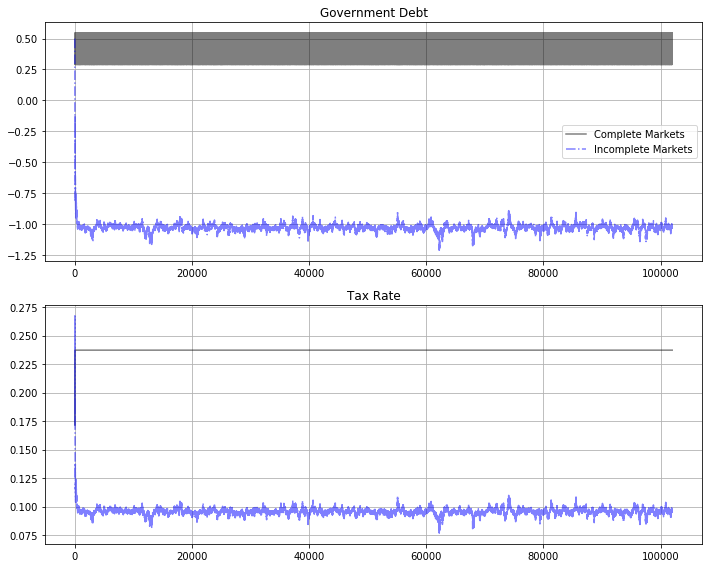

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

μ_grid = np.linspace(-0.09, 0.1, 100)

log_example = CRRAutility(π=(1 / 3) * np.ones((3, 3)),
                          G=np.array([0.1, 0.2, .3]),
                          Θ=np.ones(3))

log_example.transfers = True                        # Government can use transfers
log_sequential = SequentialAllocation(log_example)  # Solve sequential problem
log_bellman = RecursiveAllocationAMSS(log_example, μ_grid,
                                       tol=1e-12, tol_diff=1e-10)



T = 102000  # Set T to 102000 periods

sim_seq_long = log_sequential.simulate(0.5, 0, T)
sHist_long = sim_seq_long[-3]
sim_bel_long = log_bellman.simulate(0.5, 0, T, sHist_long)

titles = ['Government Debt', 'Tax Rate']

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for ax, title, id in zip(axes.flatten(), titles, [2, 3]):
    ax.plot(sim_seq_long[id], '-k', sim_bel_long[id], '-.b', alpha=0.5)
    ax.set(title=title)
    ax.grid()

axes[0].legend(('Complete Markets', 'Incomplete Markets'))
plt.tight_layout()
plt.show()

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/amss3_g1.png" style="">

  
The long simulation apparently  indicates eventual convergence to an ergodic distribution

It takes about 1000 periods to reach the ergodic distribution – an outcome that is forecast by
approximations to rates of convergence that appear in [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) and that we discuss in [a previous lecture](https://lectures.quantecon.org/py/amss2.html#)

We discard the first 2000 observations of the simulation and construct the histogram of
the part value of government debt

We obtain the following graph for the historgram of the last 100,000 observations on the par value of government debt

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/amss3_g3.png" style="">

  
The  black vertical line denotes the sample mean for the last 100,000 observations included in the historgram; the  green vertical line denots the
value of $ \frac{ {\mathcal B}^*}{E u_c} $, associated with the sample (presumably) from
the ergodic  where $ {\mathcal B}^* $ is the regression coefficient described below;  the red vertical line denotes an approximation by [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) to the mean of the ergodic
distribution that can be precomputed before sampling from the ergodic distribution, as described below

Before moving on to discuss the histogram and the vertical lines approximating the ergodic  mean of government debt in more detail, the following graphs show
government debt and taxes early in the simulation, for periods 1-100 and 101 to 200
respectively

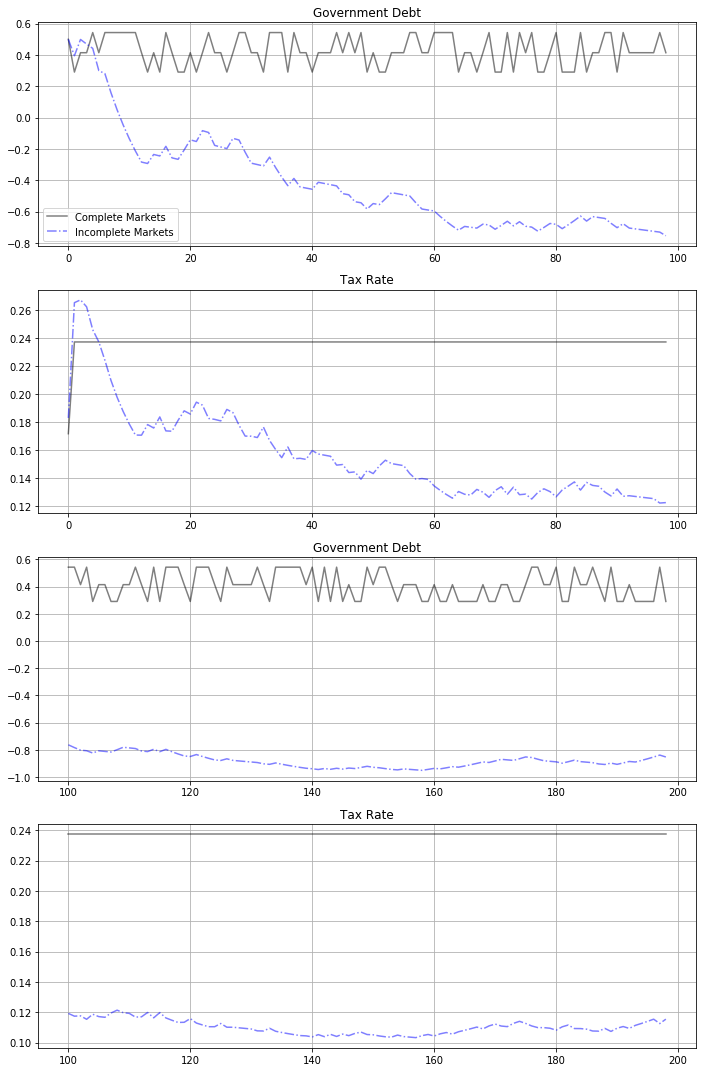

In [7]:
titles = ['Government Debt', 'Tax Rate']

fig, axes = plt.subplots(4, 1, figsize=(10, 15))

for i, id in enumerate([2, 3]):
    axes[i].plot(sim_seq_long[id][:99], '-k', sim_bel_long[id][:99], '-.b', alpha=0.5)
    axes[i+2].plot(range(100, 199), sim_seq_long[id][100:199], '-k',
                   range(100, 199), sim_bel_long[id][100:199], '-.b', alpha=0.5)
    axes[i].set(title=titles[i])
    axes[i+2].set(title=titles[i])
    axes[i].grid()
    axes[i+2].grid()

axes[0].legend(('Complete Markets', 'Incomplete Markets'))
plt.tight_layout()
plt.show()

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/amss3_g2.png" style="">

  
For the short samples early in our simulated sample of  102,000 observations, fluctuations in government debt and the tax rate
conceal the weak but inexorable force that the Ramsey planner puts into both series driving them toward ergodic distributions far from
these early observations

> - early observations are more influenced by the initial value of the par value of government debt than by the ergodic mean of the par value of government debt  
- much later observations are more influenced by the ergodic mean and are independent of the initial value of the par value of government debt  

## Asymptotic mean and rate of convergence

We apply results of [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) to interpret

> - the mean of the ergodic distribution of government debt  
- the rate of convergence  to the ergodic distribution from an arbitrary initial government debt  



We begin by computing  objects required by the theory of section III.i
of [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1)

As in [Fiscal Insurance via Fluctuating Interest Rates](https://lectures.quantecon.org/py/amss2.html#), we recall  that  [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) used a particular
notation to represent what we can regard as a  generalization of the AMSS model

We introduce some of the  [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) notation so that readers can quickly relate notation that appears in their key formulas to the notation
that we have used in previous lectures [here](https://lectures.quantecon.org/py/amss.html#) and [here](https://lectures.quantecon.org/py/amss2.html#)

BEGS work with objects $ B_t, {\mathcal B}_t, {\mathcal R}_t, {\mathcal X}_t $ that are related to  notation that we used in
earlier lectures by

$$
\begin{aligned}
{\mathcal R}_t & = \frac{u_{c,t}}{u_{c,t-1}} R_{t-1}  = \frac{u_{c,t}}{ \beta E_{t-1} u_{c,t}} \\
B_t & = \frac{b_{t+1}(s^t)}{R_t(s^t)} \\
b_t(s^{t-1}) & = {\mathcal R}_{t-1} B_{t-1} \\
{\mathcal B}_t & = u_{c,t} B_t = (\beta E_t u_{c,t+1}) b_{t+1}(s^t) \\
{\mathcal X}_t & = u_{c,t} [g_t - \tau_t n_t]
\end{aligned}
$$

[[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) call $ {\mathcal X}_t $ the **effective** government deficit, and $ {\mathcal B}_t $ the **effective** government debt

Equation (44) of [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) expresses the time $ t $ state $ s $ government budget constraint as


<a id='equation-eq-fiscal-risk-1'></a>
$$
{\mathcal B}(s) = {\mathcal R}_\tau(s, s_{-}) {\mathcal B}_{-} + {\mathcal X}_{\tau} (s) \tag{1}
$$

where the dependence on $ \tau $ is to remind us that these objects depend on the tax rate;  $ s_{-} $ is last period’s Markov state

BEGS interpret random variations in the right side of [(1)](#equation-eq-fiscal-risk-1)  as **fiscal risks** generated by

- interest-rate-driven fluctuations in time $ t $ effective payments due on the government portfolio, namely,
  $ {\mathcal R}_\tau(s, s_{-}) {\mathcal B}_{-} $,  and  
- fluctuations in the effective government deficit $ {\mathcal X}_t $  

### Asymptotic mean

BEGS give conditions under which the ergodic mean of $ {\mathcal B}_t $ approximately satisfies the equation


<a id='equation-prelim-formula-1'></a>
$$
{\mathcal B}^* = - \frac{\rm cov^{\infty}({\mathcal R}_t, {\mathcal X_t})}{\rm var^{\infty}({\mathcal R}_t)} \tag{2}
$$

where the superscript $ \infty $ denotes a moment taken with respect to an ergodic distribution

Formula [(2)](#equation-prelim-formula-1) represents $ {\mathcal B}^* $ as a regression coefficient of $ {\mathcal X}_t $ on $ {\mathcal R}_t $ in the ergodic
distribution

Regression coefficient $ {\mathcal B}^* $ solves  a variance-minimization problem:


<a id='equation-eq-criterion-fiscal-1'></a>
$$
{\mathcal B}^* = {\rm argmin}_{\mathcal B}  {\rm var}^\infty ({\mathcal R} {\mathcal B} + {\mathcal X}) \tag{3}
$$

The minimand in criterion [(3)](#equation-eq-criterion-fiscal-1)  measures fiscal risk associated with a given tax-debt policy that appears on the right side
of equation [(1)](#equation-eq-fiscal-risk-1)

Expressing formula [(2)](#equation-prelim-formula-1) in terms of  our notation tells us that the ergodic mean of the par value $ b $ of government debt in the
AMSS model should approximately equal


<a id='equation-key-formula-1'></a>
$$
\hat b = \frac{\mathcal B^*}{\beta E( E_t u_{c,t+1})} = \frac{\mathcal B^*}{\beta E( u_{c,t+1} )} \tag{4}
$$

where mathematical expectations are taken with respect to the ergodic distribution

### Rate of convergence

BEGS also derive the following  approximation to the rate of convergence to $ {\mathcal B}^{*} $ from an arbitrary initial condition

> 
<a id='equation-rate-of-convergence-1'></a>
$$
\frac{ E_t  ( {\mathcal B}_{t+1} - {\mathcal B}^{*} )} { ( {\mathcal B}_{t} - {\mathcal B}^{*} )} \approx \frac{1}{1 + \beta^2 {\rm var}^\infty ({\mathcal R} )} \tag{5}
$$


(See the equation above equation (47) in [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1))

### More advanced material

The remainder of this lecture is about  technical material based on  formulas from [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1)

The topic is interpreting  and extending formula [(3)](#equation-eq-criterion-fiscal-1) for the ergodic mean $ {\mathcal B}^* $

### Chicken and egg

Attributes of the ergodic distribution for $ {\mathcal B}_t $  appear
on the right side of  formula [(3)](#equation-eq-criterion-fiscal-1) for the ergodic mean $ {\mathcal B}^* $

Thus,  formula  [(3)](#equation-eq-criterion-fiscal-1) is not useful for estimating  the mean of the ergodic in advance of actually computing the ergodic distribution

> - we need to know the  ergodic distribution to compute the right side of formula [(3)](#equation-eq-criterion-fiscal-1)  



So the primary use of equation [(3)](#equation-eq-criterion-fiscal-1) is how  it  confirms that
the ergodic distribution solves a fiscal-risk minimization problem

As an example, notice how we used the formula for the mean of $ {\mathcal B} $ in the ergodic distribution of the special AMSS economy in
[Fiscal Insurance via Fluctuating Interest Rates](https://lectures.quantecon.org/py/amss2.html#)

> - **first** we computed the ergodic distribution using a reverse-engineering construction  
- **then** we verified that $ {\mathcal B} $  agrees with the mean of that distribution  

### Approximating $ {\mathcal B}^* $

[[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) propose  an approximation to  $ {\mathcal B}^* $ that can be computed without first knowing the
ergodic distribution

To  construct the BEGS  approximation to $ {\mathcal B}^* $, we just follow steps set forth on pages 648 - 650 of section III.D of
[[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1)

- notation in BEGS might be confusing at first sight, so
  it is important to stare and digest before computing  
- there are also some sign errors in the [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) text that we’ll want
  to correct  


Here is a step-by-step description of the [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) approximation procedure

### Step by step

**Step 1:** For a given $ \tau $ we  compute a vector of
values $ c_\tau(s), s= 1, 2, \ldots, S $ that satisfy

$$
(1-\tau) c_\tau(s)^{-\sigma} - (c_{\tau}(s) + g(s))^{\gamma} = 0
$$

This is a nonlinear equation to be solved for
$ c_{\tau}(s), s = 1, \ldots, S $

$ S=3 $ in our case, but we’ll write code for a general integer
$ S $

**Typo alert:** Please note that there is a sign error in equation (42)
of [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) – it should be a minus rather than a plus in the middle

> - We have made the appropriate correction in the above equation  



**Step 2:** Knowing $ c_\tau(s), s=1, \ldots, S $ for a given
$ \tau $, we want to compute the random variables

$$
{\mathcal  R}_\tau(s) = \frac{c_\tau(s)^{-\sigma}}{\beta \sum_{s'=1}^S c_\tau(s')^{-\sigma} \pi(s')}
$$

and

$$
{\mathcal X}_\tau(s) = (c_\tau(s) + g(s))^{1+ \gamma} - c_\tau(s)^{1-\sigma}
$$

each for $ s= 1, \ldots, S $

BEGS call $ {\mathcal  R}_\tau(s) $
the **effective return** on risk-free debt and they call
$ {\mathcal X}_\tau(s) $ the **effective government deficit**

**Step 3:** With the preceding objects in hand, for a given
$ {\mathcal B} $, we seek a $ \tau $ that satisfies

$$
{\mathcal B} = - \frac{\beta} {1-\beta} E {\mathcal X_\tau} \equiv - \frac{\beta} {1-\beta} \sum_{s} {\mathcal X}_\tau(s) \pi(s)
$$

This equation says that at a constant discount factor $ \beta $,  equivalent government debt $ {\mathcal B} $ equals the
present value of the mean effective government **surplus**

**Typo alert**: there is a sign error in equation (46) of [[BEGS17]](https://lectures.quantecon.org/py/zreferences.html#begs1) –the left
side should be multiplied by $ -1 $

> - We have made this correction in the above equation  



For a given $ {\mathcal B} $, let a $ \tau $ that solves the
above equation be called $ \tau(\mathcal B) $

We’ll use a Python root solver to finds a $ \tau $ that this
equation for a given $ {\mathcal B} $

We’ll use this function to induce a function $ \tau({\mathcal B}) $

**Step 4:** With a Python program that computes
$ \tau(\mathcal B) $ in hand, next we write a Python function to
compute the random variable

$$
J({\mathcal B})(s) =  \mathcal R_{\tau({\mathcal B})}(s) {\mathcal B} + {\mathcal X}_{\tau({\mathcal B})}(s) ,  \quad s = 1, \ldots, S
$$

**Step 5:** Now that we have a machine to compute the random variable
$ J({\mathcal B})(s), s= 1, \ldots, S $, via  a composition of  Python
functions, we can use the population variance  function that we
defined in the code above to construct a function
$ {\rm var}(J({\mathcal B})) $

We put $ {\rm var}(J({\mathcal B})) $ into a function minimizer and
compute

$$
{\mathcal B}^* = {\rm argmin}_{\mathcal B} {\rm var } (J({\mathcal B}) )
$$

**Step 6:** Next we take the minimizer $ {\mathcal B}^* $ and the
Python functions for computing means and variances and compute

$$
{\rm rate} = \frac{1}{1 + \beta^2 {\rm var}( {\mathcal R}_{\tau({\mathcal B}^*)} )}
$$

Ultimate outputs of this string of calculations are two scalars

$$
({\mathcal B}^*, {\rm rate} )
$$

**Step 7:** Compute the divisor

$$
div = {\beta E u_{c,t+1}}
$$

and then compute the mean of the par value of government debt in the AMSS model

$$
\hat b = \frac{ {\mathcal B}^*}{div}
$$

In the two-Markov-state AMSS economy in [Fiscal Insurance via Fluctuating Interest Rates](https://lectures.quantecon.org/py/amss2.html#),
$ E_t u_{c,t+1} = E u_{c,t+1} $ in the ergodic distribution and we  have confirmed that
this formula very accurately describes a **constant** par value of government debt that

> - supports full fiscal insurance via fluctuating interest parameters, and  
- is the limit of government debt as $ t \rightarrow +\infty $  



In the three-Markov-state economy of this lecture, the par value of government debt fluctuates in a history-dependent way even asymptotically

In this economy, $ \hat b $ given by the above formula approximates the mean of the ergodic distribution of  the par value of  government debt

> - this is the red vertical line plotted in the histogram of the last 100,000 observations of our simulation of the  par value of government debt plotted above  
- the approximation is fairly accurate but not perfect  
- so while the approximation circumvents the chicken and egg problem surrounding
  the much better approximation associated with the green vertical line, it does so by enlarging the approximation error  

### Execution

Now let’s move on to compute things step by step

#### Step 1

In [8]:
u = CRRAutility(π=(1 / 3) * np.ones((3, 3)),
                G=np.array([0.1, 0.2, .3]),
                Θ=np.ones(3))

τ = 0.05           # Initial guess of τ (to displays calcs along the way)
S = len(u.G)       # Number of states

def solve_c(c, τ, u):
    return (1 - τ) * c**(-u.σ) - (c + u.G)**u.γ

c = root(solve_c, np.ones(S), args=(τ, u)).x  # .x returns the result from root
c

array([0.93852387, 0.89231015, 0.84858872])

In [9]:
root(solve_c, np.ones(S), args=(τ, u))

    fjac: array([[-0.99990816, -0.00495351, -0.01261467],
       [-0.00515633,  0.99985715,  0.01609659],
       [-0.01253313, -0.01616015,  0.99979086]])
     fun: array([ 5.61814373e-10, -4.76900741e-10,  1.17474919e-11])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.55568331e-08, 1.28322481e-08, 7.89913426e-11])
       r: array([ 4.26943131,  0.08684775, -0.06300593, -4.71278821, -0.0743338 ,
       -5.50778548])
  status: 1
 success: True
       x: array([0.93852387, 0.89231015, 0.84858872])

#### Step 2

In [10]:
n = c + u.G   # compute labor supply

### Note about code

Remember that in our code $ \pi $ is a $ 3 \times 3 $ transition
matrix

But because we are studying an i.i.d. case, $ \pi $ has identical
rows and we only need to compute objects for one row of $ \pi $

This explains why at some places below we set $ s=0 $ just to pick
off the first row of $ \pi $ in the calculations

### Code

First, let’s compute $ {\mathcal R} $ and $ {\mathcal X} $
according to our formulas

In [11]:
def compute_R_X(τ, u, s):
    c = root(solve_c, np.ones(S), args=(τ, u)).x  # Solve for vector of c's
    div = u.β * (u.Uc(c[0], n[0]) * u.π[s, 0]  +  u.Uc(c[1], n[1]) * u.π[s, 1] +  u.Uc(c[2], n[2]) * u.π[s, 2])
    R = c**(-u.σ) / (div)
    X = (c + u.G)**(1 + u.γ) - c**(1 - u.σ)
    return R, X

In [12]:
c**(-u.σ) @ u.π

array([1.25997521, 1.25997521, 1.25997521])

In [13]:
u.π

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

We only want unconditional expectations because we are in an iid case

So we’ll set $ s=0 $ and just pick off expectations associated with
the first row of $ \pi $

In [14]:
s = 0

R, X = compute_R_X(τ, u, s)

Let’s look at the random variables $ {\mathcal R}, {\mathcal X} $

In [15]:
R

array([1.00116313, 1.10755123, 1.22461897])

In [16]:
mean(R, s)

1.1111111111111112

In [17]:
X

array([0.05457803, 0.18259396, 0.33685546])

In [18]:
mean(X, s)

0.19134248445303795

In [19]:
X @ u.π

array([0.19134248, 0.19134248, 0.19134248])

#### Step 3

In [20]:
def solve_τ(τ, B, u, s):
    R, X = compute_R_X(τ, u, s)
    return ((u.β - 1) / u.β) * B - X @ u.π[s]

Note that $ B $ is a scalar

Let’s try out our method computing $ \tau $

In [21]:
s = 0
B = 1.0

τ = root(solve_τ, .1, args=(B, u, s)).x[0]  # Very sensitive to starting value
τ

0.2740159773695818

In the above cell, B is fixed at 1 and $ \tau $ is to be computed as
a function of B

Note that 0.2 is the initial value for $ \tau $ in the root-finding
algorithm

#### Step 4

In [22]:
def min_J(B, u, s):
    τ = root(solve_τ, .5, args=(B, u, s)).x[0]  # very sensitive to initial value of τ
    R, X = compute_R_X(τ, u, s)
    return variance(R * B + X, s)

In [23]:
min_J(B, u, s)

0.035564405653720765

#### Step 6

In [24]:
from scipy.optimize import minimize

B_star = minimize(min_J, .5, args=(u, s)).x[0]
B_star

-1.199483167941158

In [25]:
n = c + u.G  # compute labor supply

In [26]:
div = u.β * (u.Uc(c[0], n[0]) * u.π[s, 0]  +  u.Uc(c[1], n[1]) * u.π[s, 1] +  u.Uc(c[2], n[2]) * u.π[s, 2])

In [27]:
B_hat = B_star/div
B_hat

-1.0577661126390971

In [28]:
τ_star = root(solve_τ, 0.05, args=(B_star, u, s)).x[0]
τ_star

0.09572916798461703

In [29]:
R_star, X_star = compute_R_X(τ_star, u, s)
R_star, X_star

(array([0.9998398 , 1.10746593, 1.2260276 ]),
 array([0.0020272 , 0.12464752, 0.27315299]))

In [30]:
rate = 1 / (1 + u.β**2 * variance(R_star, s))
rate

0.9931353432732218

In [31]:
root(solve_c, np.ones(S), args=(τ_star, u)).x

array([0.9264382 , 0.88027117, 0.83662635])